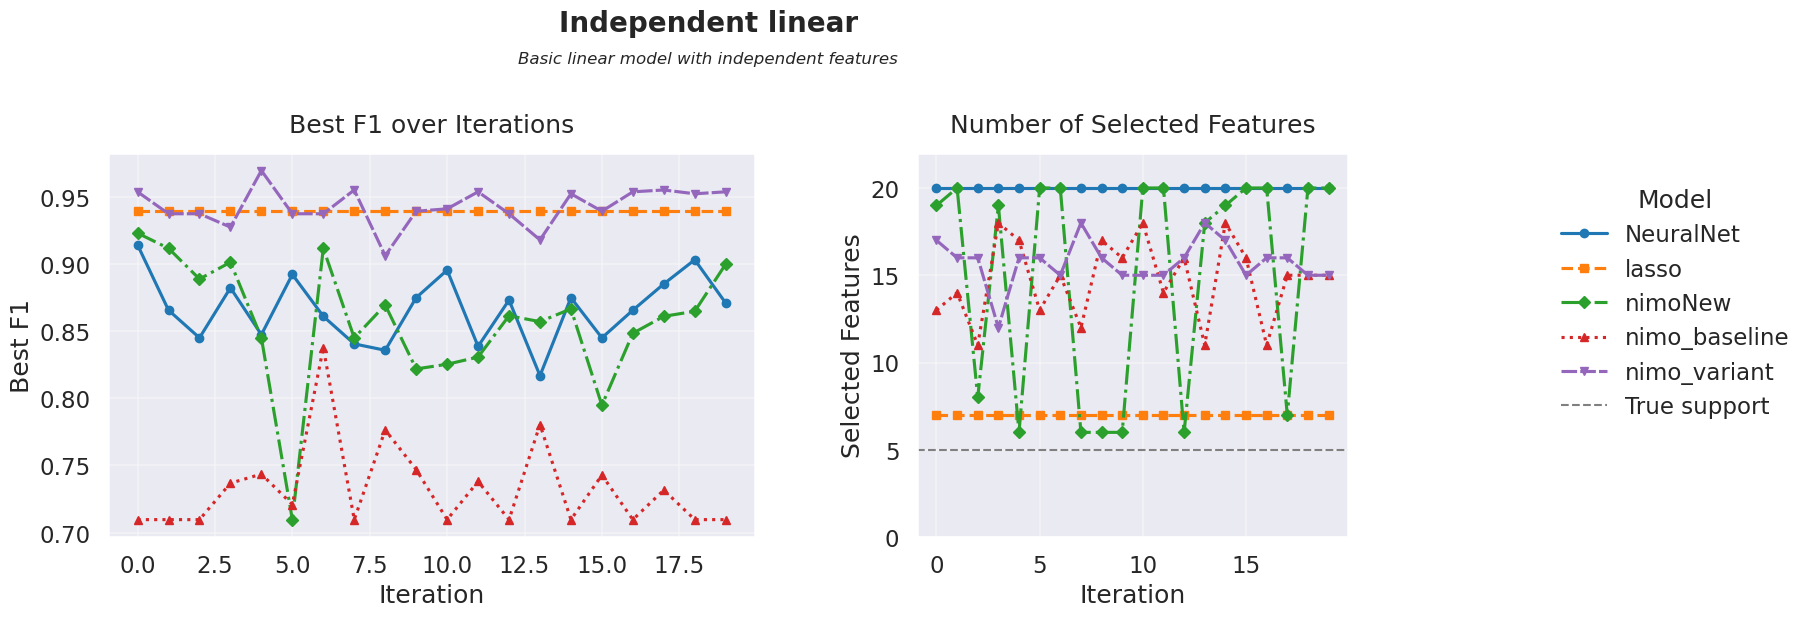

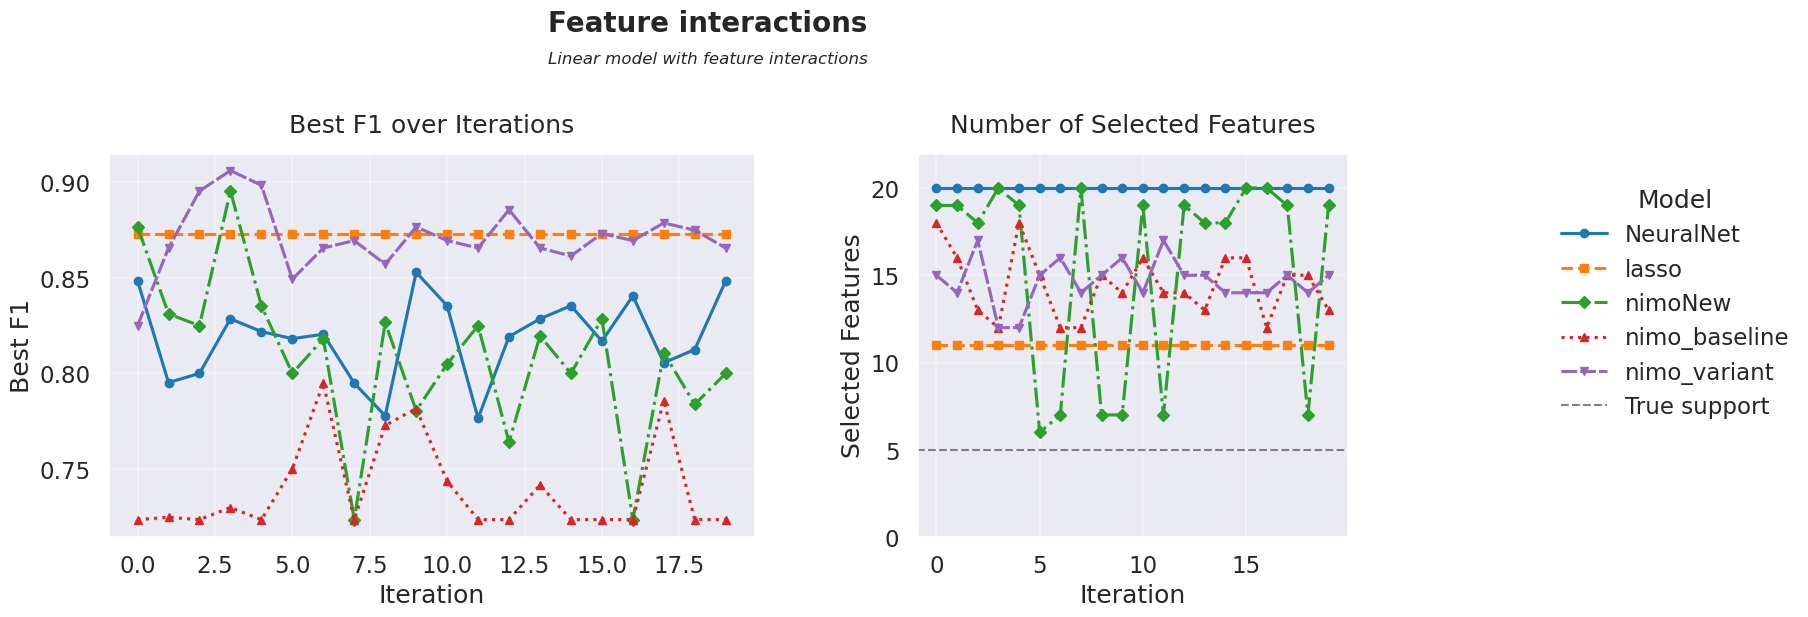

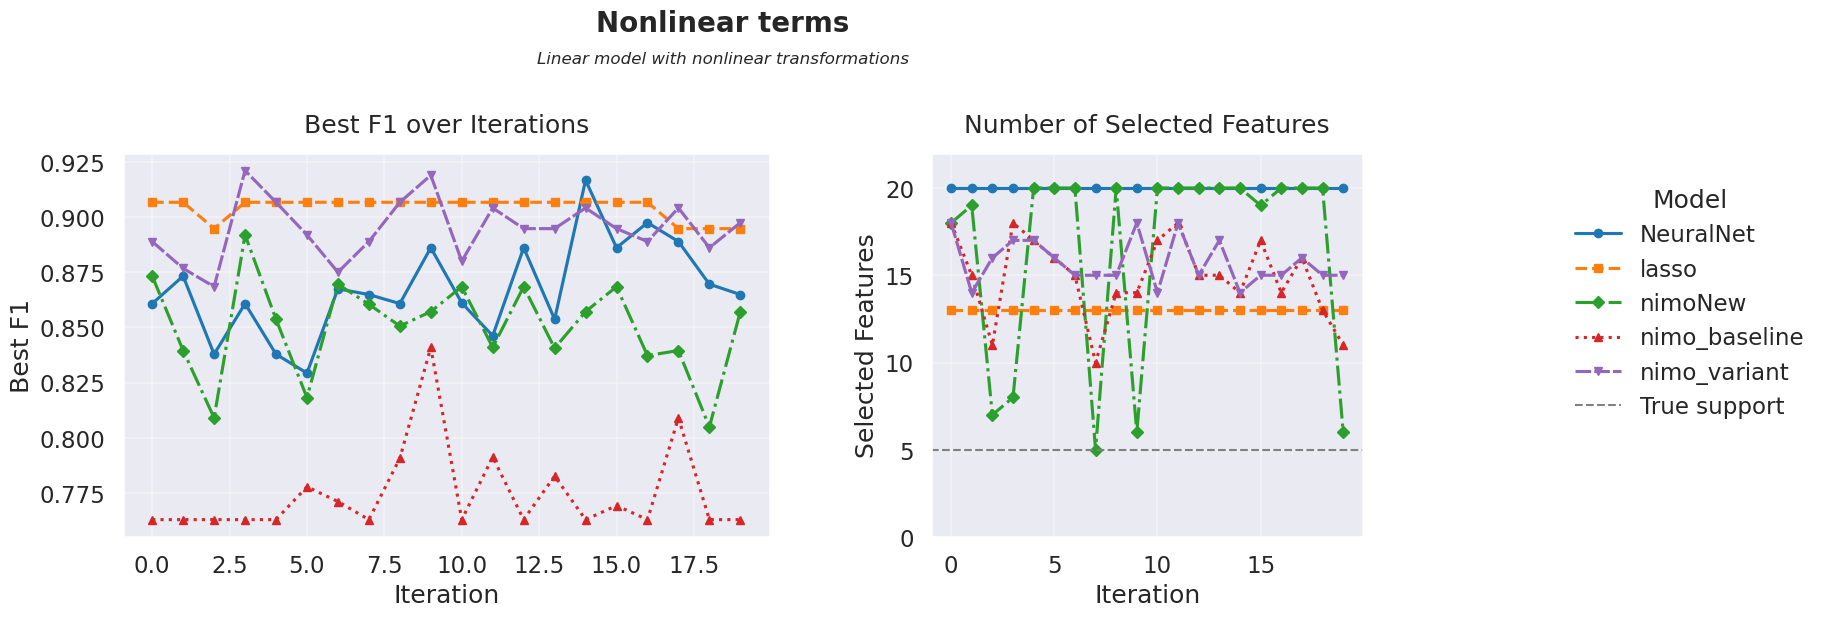

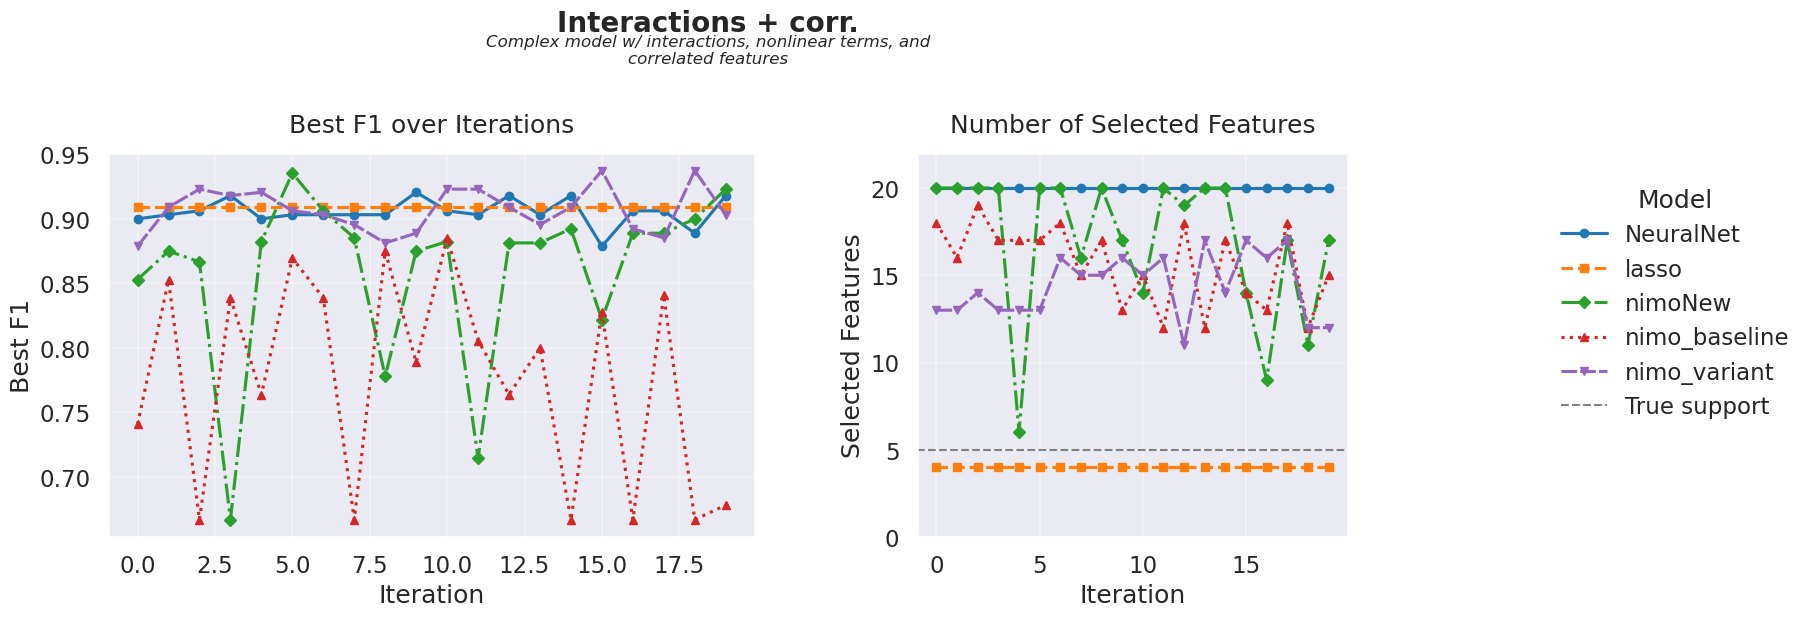

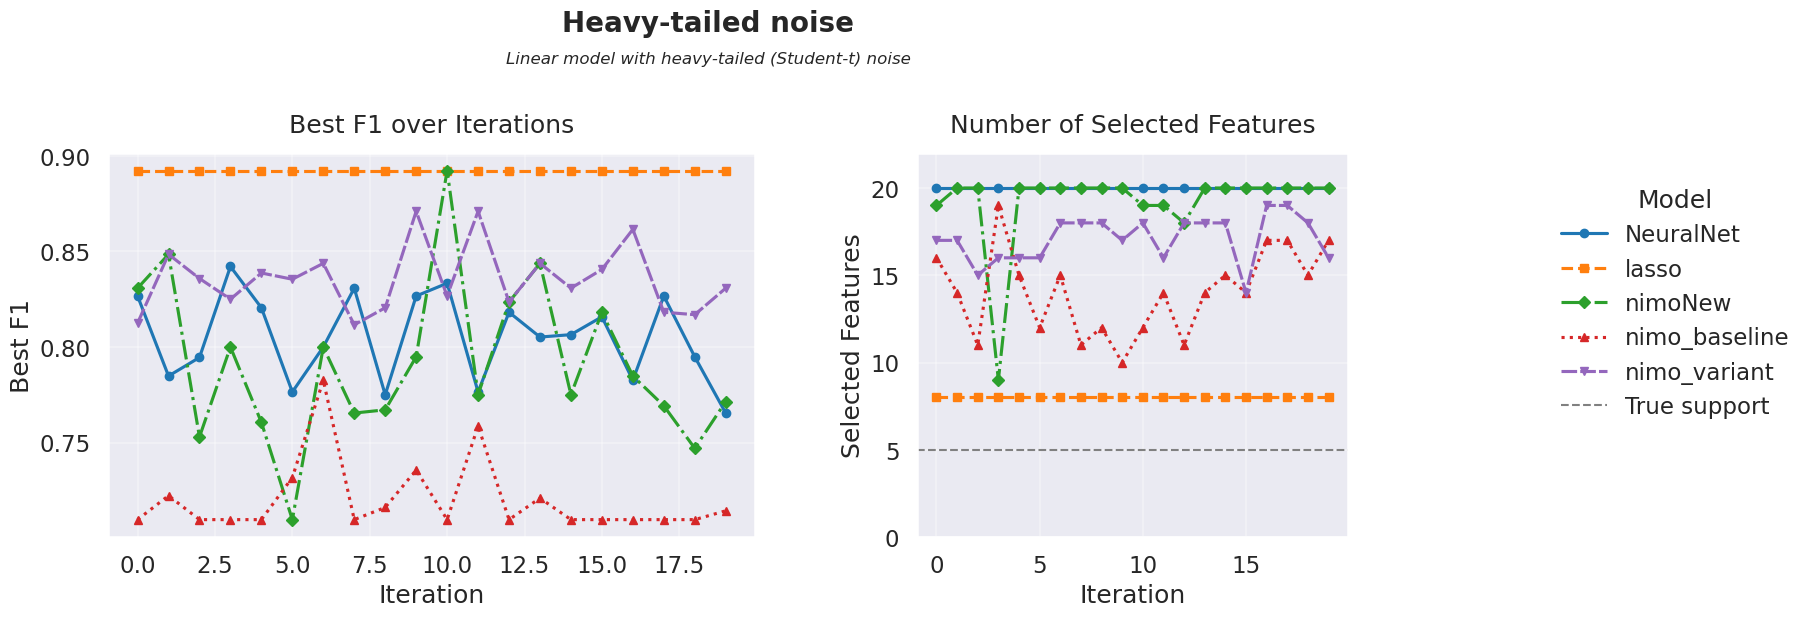

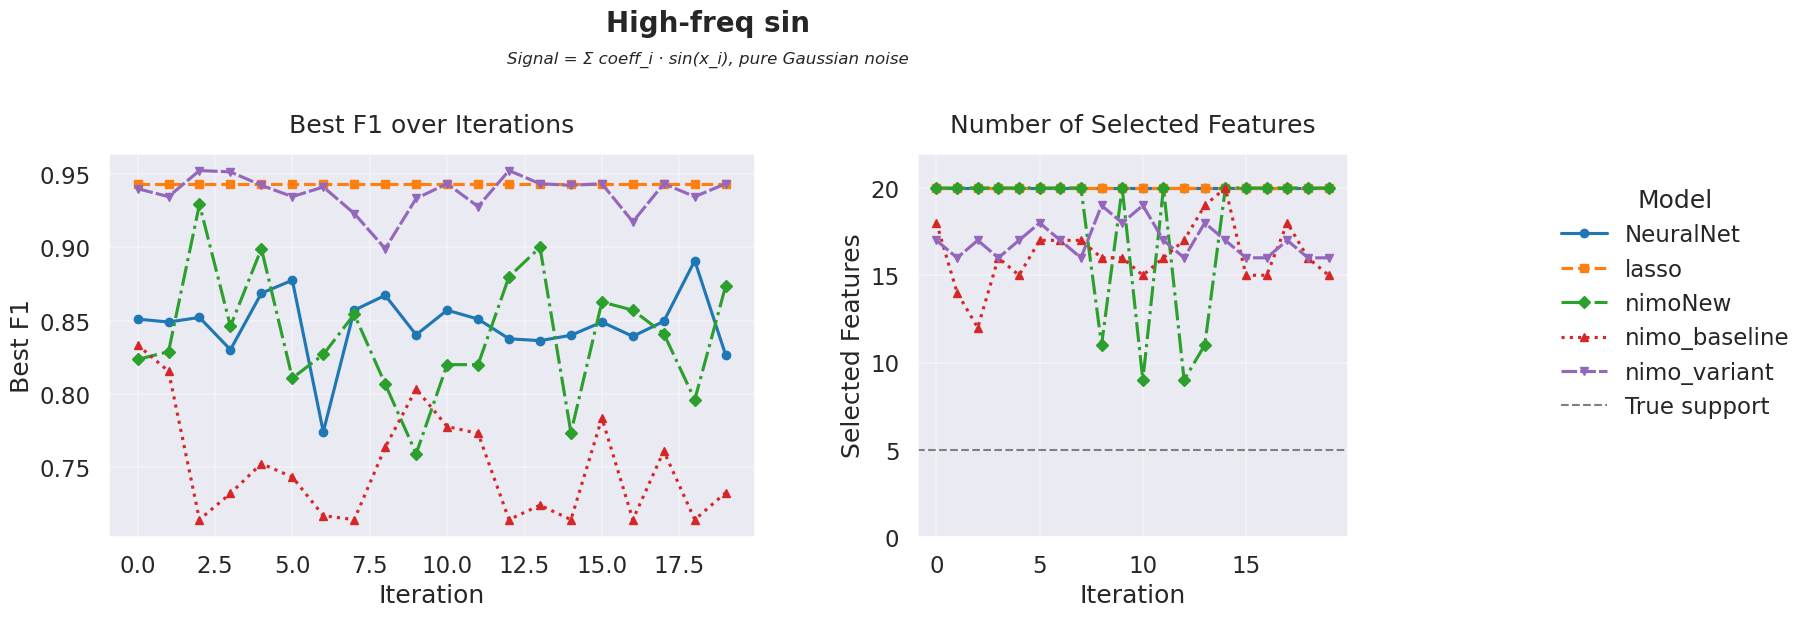

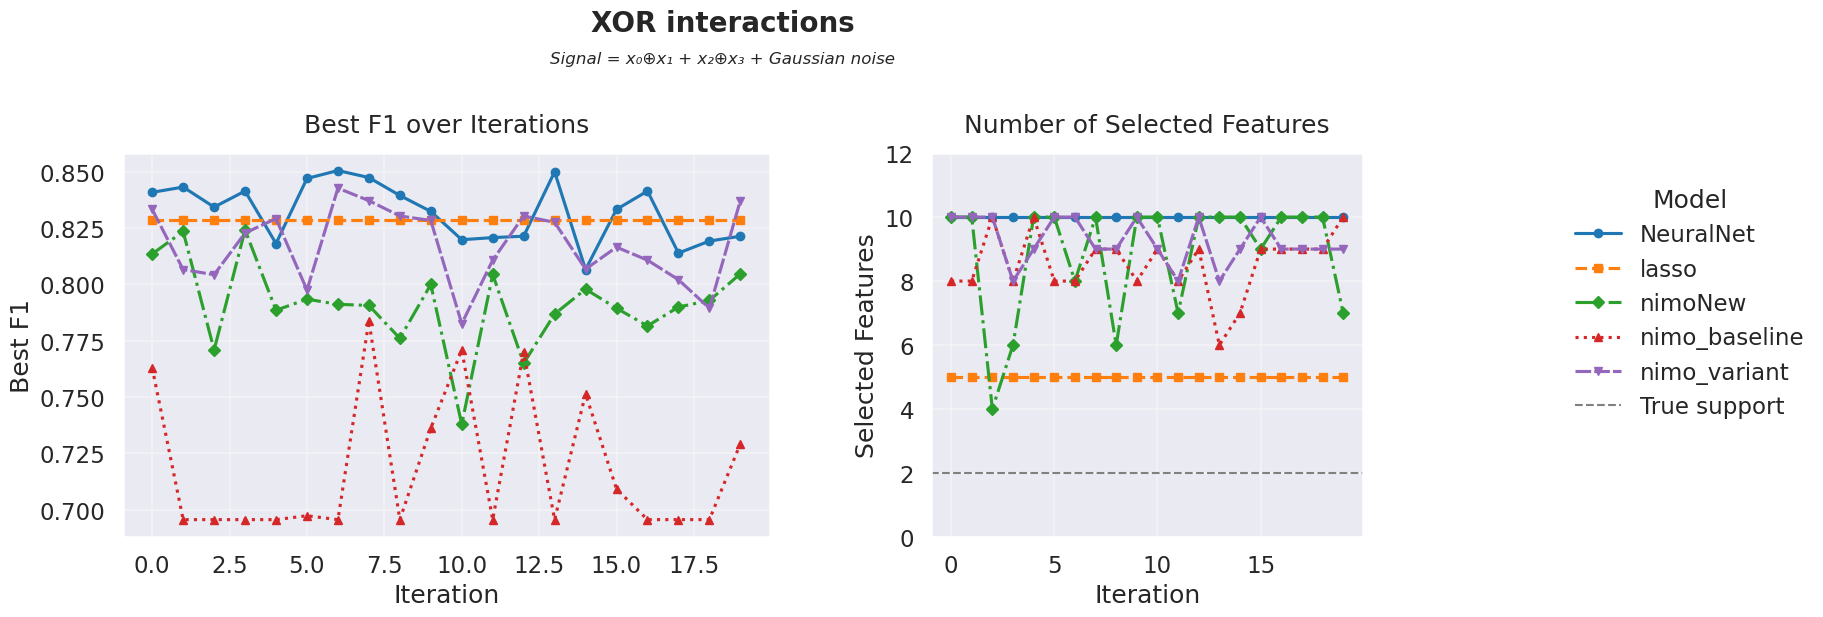

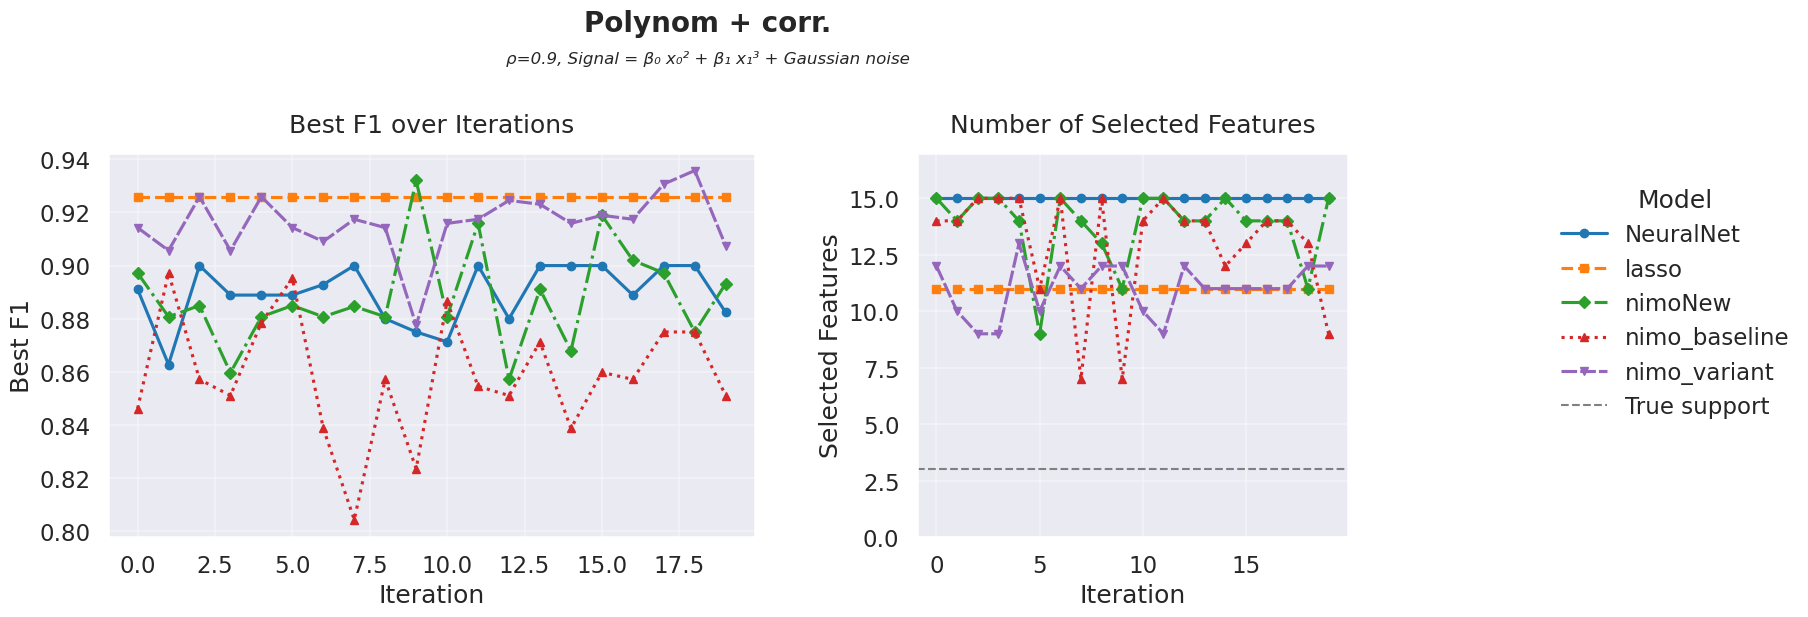

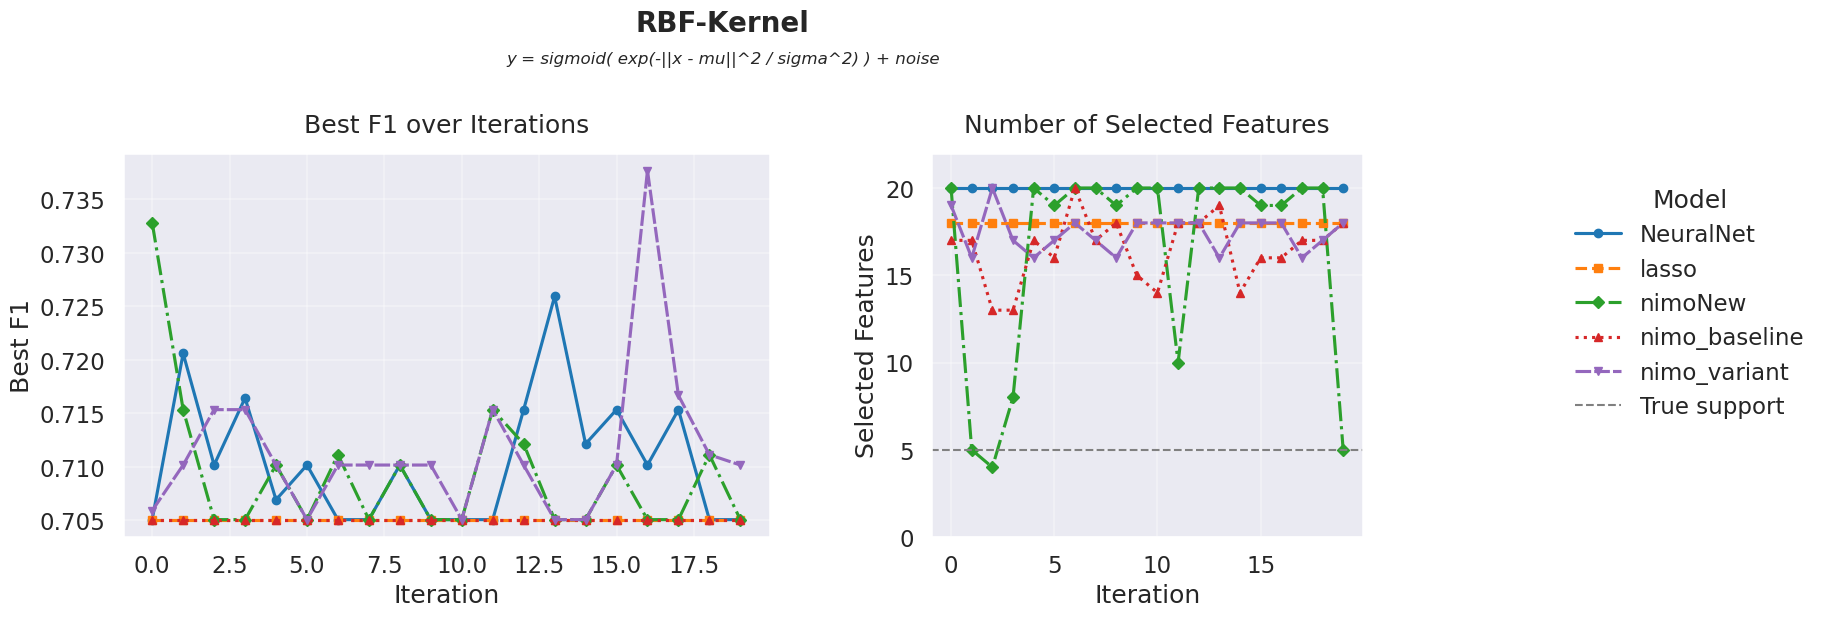

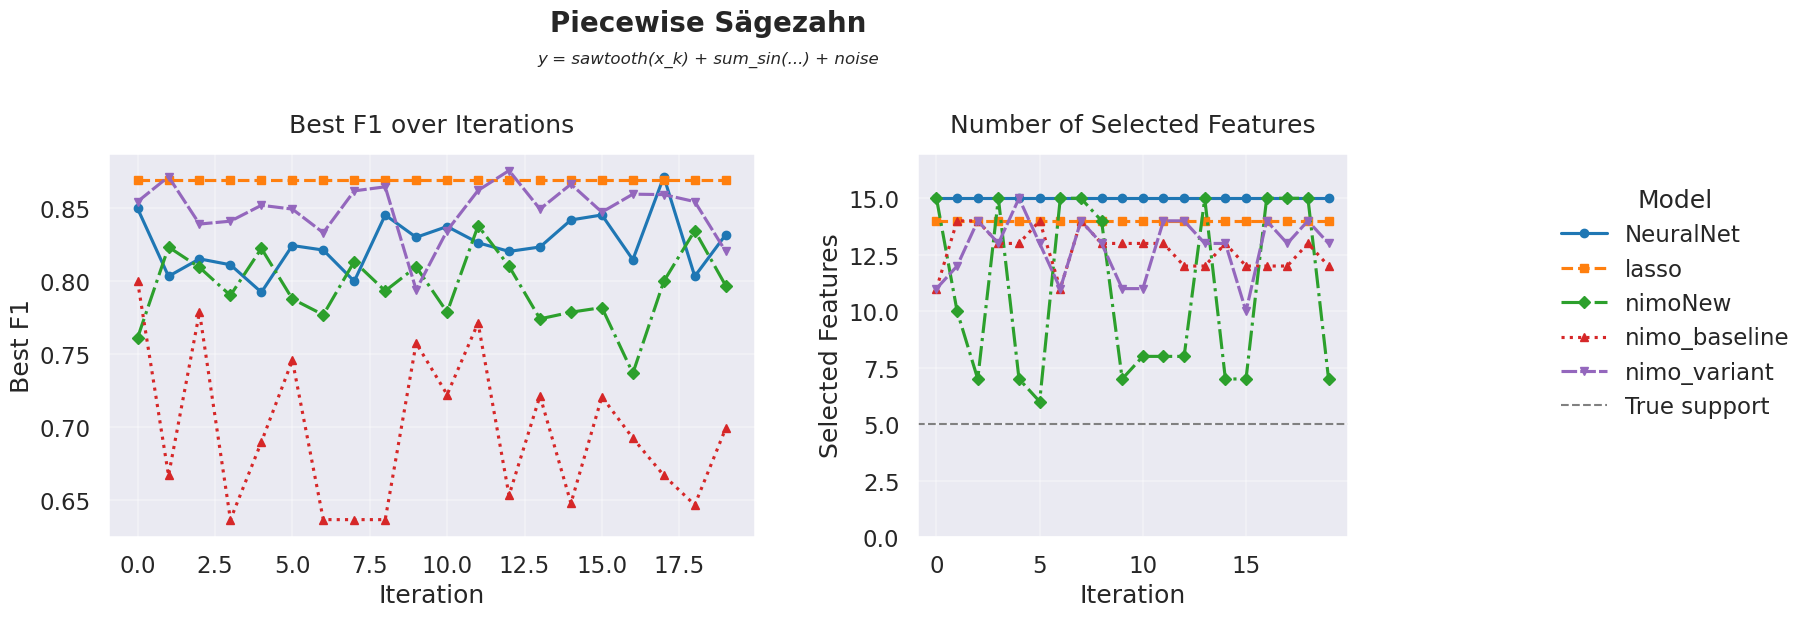

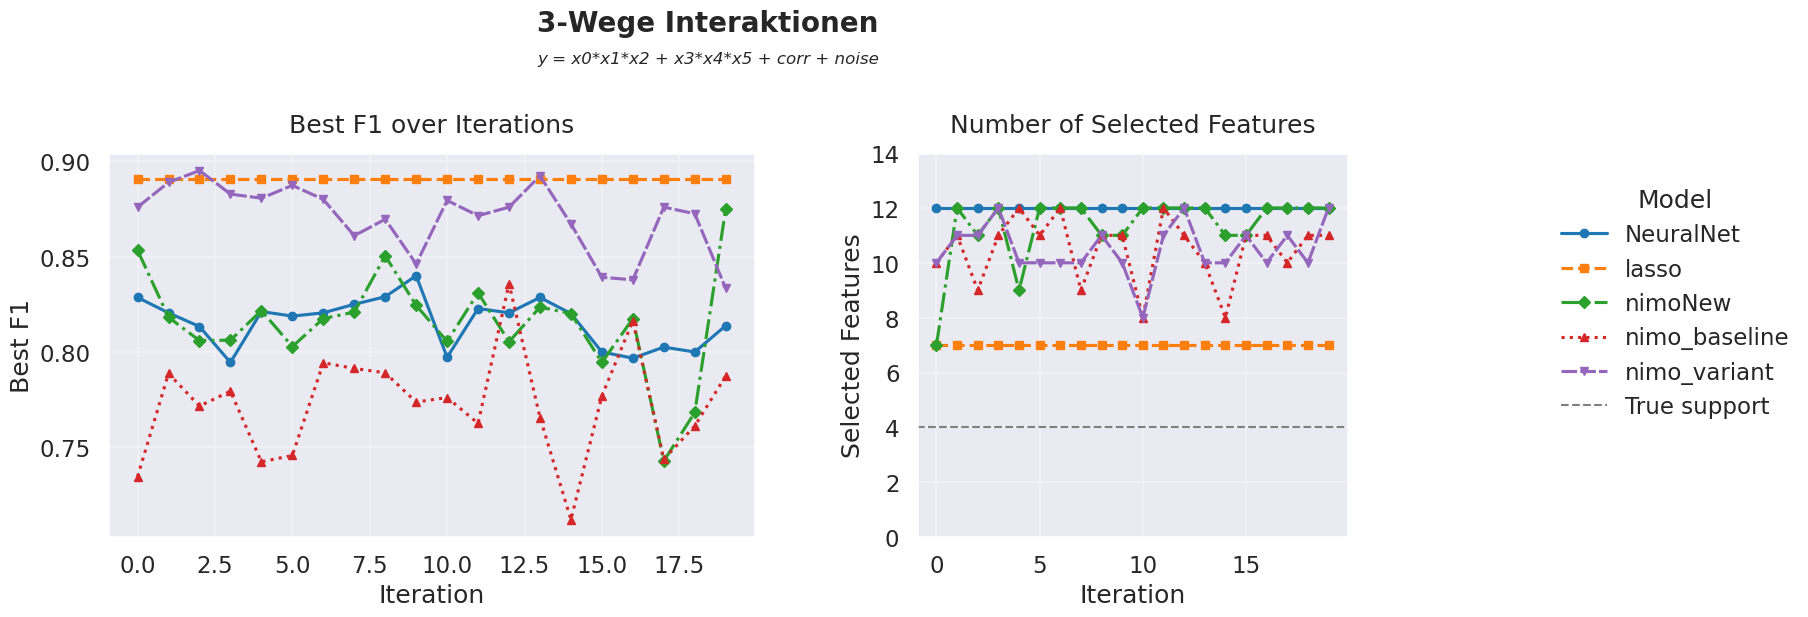

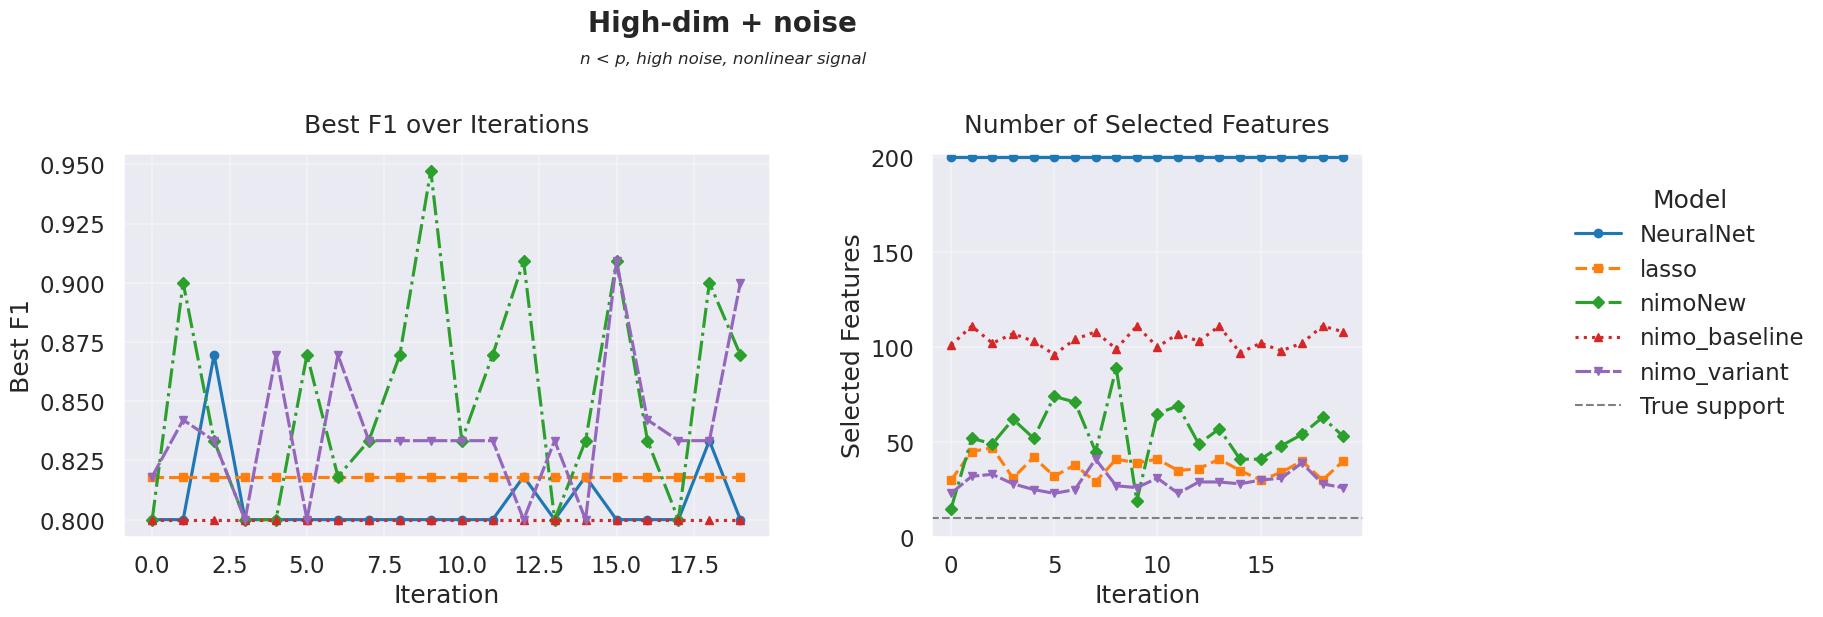

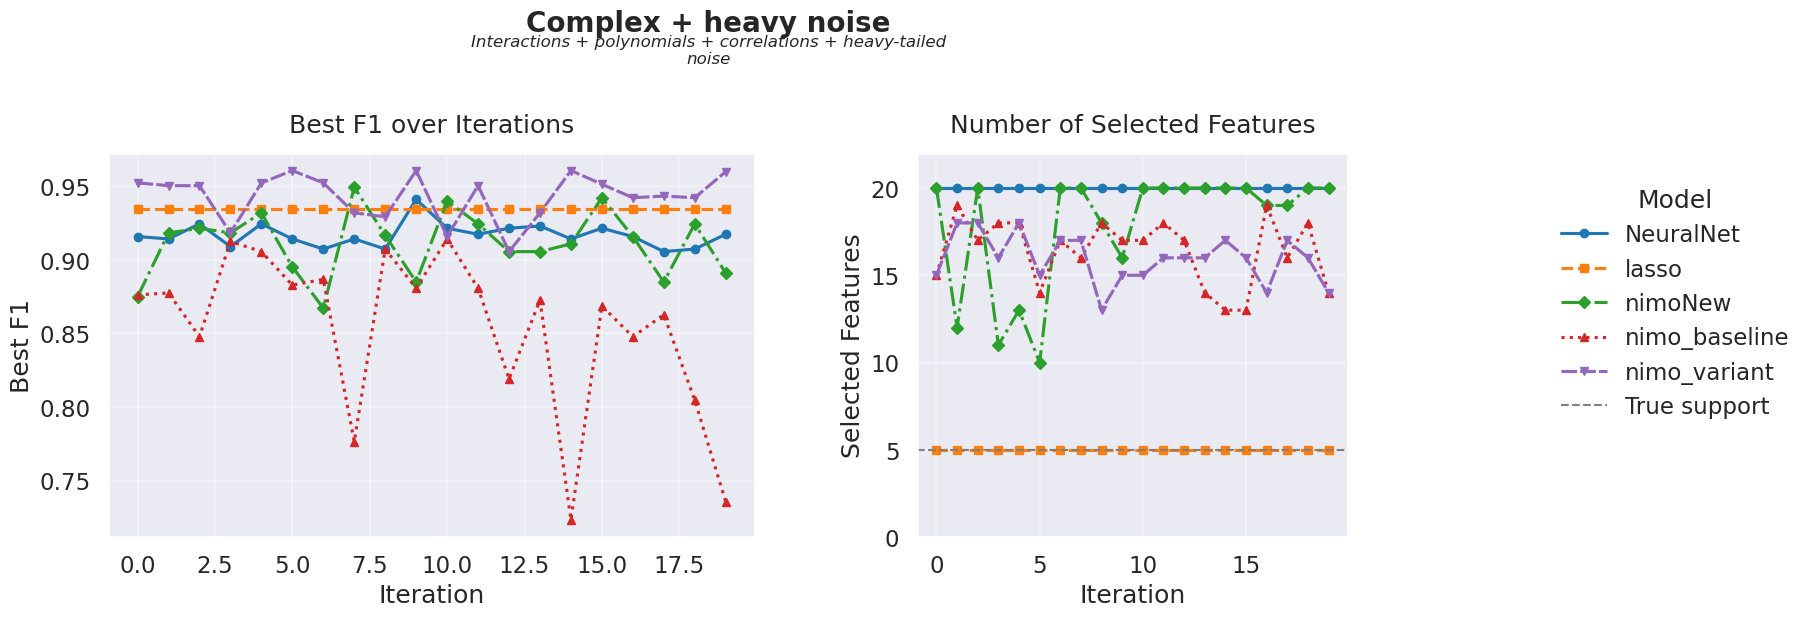

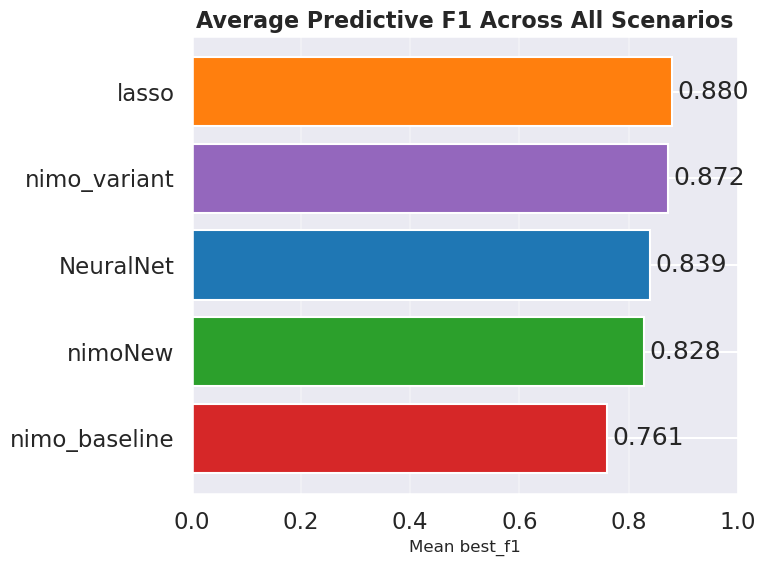

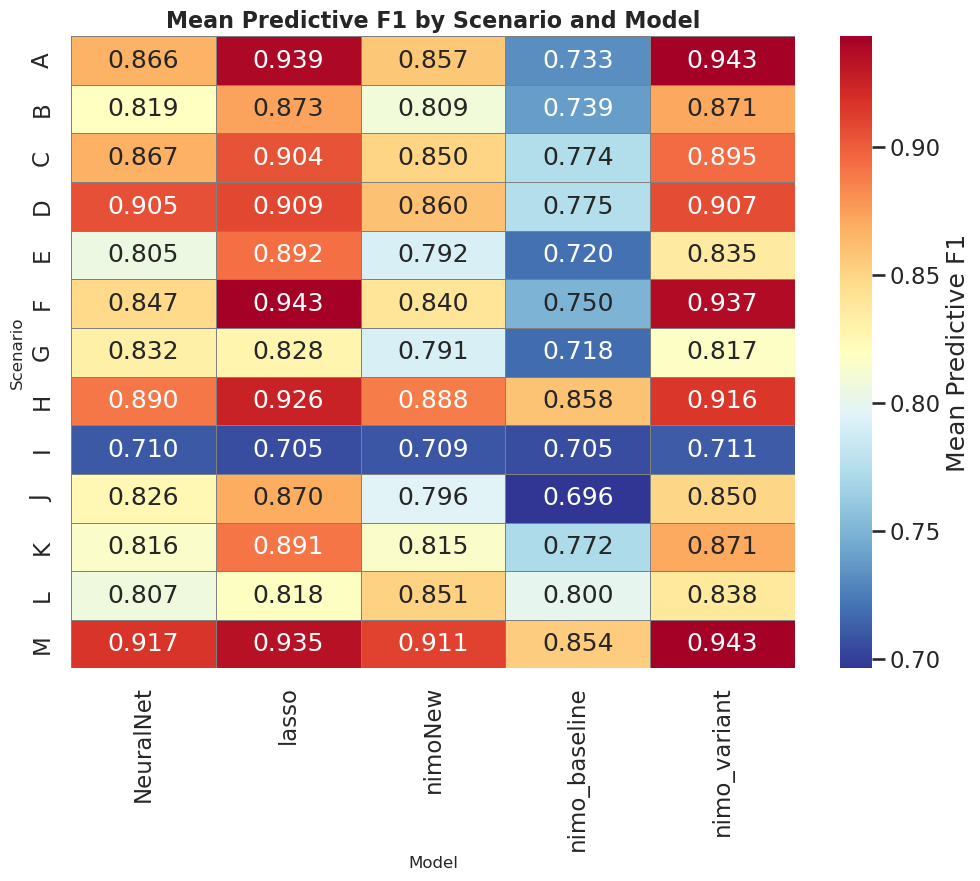

In [8]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

import matplotlib as mpl
# Ensure we get DejaVu Sans (ships with matplotlib & covers most unicode):
mpl.rcParams['font.family'] = 'DejaVu Sans'
# You can also explicitly set:
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']


sns.set_context("talk")

# -------------------------------
# 1) Daten einlesen & vorbereiten
# -------------------------------
df = pd.read_csv('../results/synthetic/all_model_results_synthetic.csv')
if 'error' in df.columns:
    df = df[df['error'].isna()].reset_index(drop=True)

# selected_features parsen und n_selected berechnen
df['selected_features'] = (
    df['selected_features']
      .fillna('[]')
      .apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else [])
)
df['n_selected'] = df['selected_features'].apply(len)

# numerische Spalten casten
for col in ['best_f1', 'n_selected', 'f1_recovery', 'n_true_features']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Short/Long Descriptions
short_map = df.groupby('scenario')['scenario_short'].first().to_dict()
long_map  = df.groupby('scenario')['scenario_long'].first().to_dict()


scenarios = sorted(df['scenario'].unique())
methods   = sorted(df['model_name'].unique())

# Farben, Linienstile, Marker
palette    = dict(zip(methods, sns.color_palette("tab10", n_colors=len(methods))))
linestyles = ['-', '--', '-.', ':', (0, (5,1))]
markers    = ['o', 's', 'D', '^', 'v']

# -------------------------------
# 2) Pro Scenario: 2‑Spalten‑Layout
# -------------------------------
for scen in scenarios:
    grp        = df[df['scenario']==scen]
    desc_short = short_map[scen]
    desc_long  = long_map.get(scen, "")

    # Wir machen das Figure etwas höher, damit mehr Platz ist
    fig, axes = plt.subplots(
        1, 2,
        figsize=(16, 6),                  # mehr Höhe
        gridspec_kw={'width_ratios':[3,2]}
    )

    # Abstand oben großzügig freilassen
    fig.subplots_adjust(top=0.75, wspace=0.3)

    # Haupt‐Titel (knapp unter 1.0)
    fig.suptitle(
        desc_short,
        fontsize=20, fontweight='bold',
        y=0.99            # Position unter der Top-Grenze
    )

    # Untertitel direkt darunter
    wrapped = "\n".join(textwrap.wrap(desc_long, width=60))
    fig.text(
        0.5, 0.90,        # etwas tiefer als suptitle
        wrapped,
        ha='center', fontsize=12, style='italic'
    )

    # — Linke Achse —
    ax1 = axes[0]
    for i, method in enumerate(methods):
        sub = grp[grp['model_name']==method]
        if sub.empty: continue
        ax1.plot(
            sub['iteration'], sub['best_f1'],
            color=palette[method],
            linestyle=linestyles[i % len(linestyles)],
            marker=markers[i % len(markers)],
            markersize=6,
            label=method
        )
    ax1.set_title("Best F1 over Iterations", pad=15)
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Best F1")
    ax1.grid(alpha=0.3)

    # — Rechte Achse —
    ax2 = axes[1]
    local_max = grp['n_selected'].max()
    true_max  = grp['n_true_features'].iloc[0] if 'n_true_features' in grp.columns else 0
    ylim      = max(local_max, true_max) + 2

    for i, method in enumerate(methods):
        sub = grp[grp['model_name']==method]
        if sub.empty: continue
        ax2.plot(
            sub['iteration'], sub['n_selected'],
            color=palette[method],
            linestyle=linestyles[i % len(linestyles)],
            marker=markers[i % len(markers)],
            markersize=6,
            label=method
        )
    if 'n_true_features' in grp.columns:
        ax2.axhline(true_max, ls='--', color='gray', linewidth=1.5, label='True support')
    ax2.set_title("Number of Selected Features", pad=15)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Selected Features")
    ax2.set_ylim(0, ylim)
    ax2.grid(alpha=0.3)

    # Gemeinsame Legende rechts außen
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    handles, labels = [], []
    for h, l in zip(h1 + h2, l1 + l2):
        if l not in labels:
            handles.append(h); labels.append(l)

    fig.legend(
        handles, labels, title="Model",
        bbox_to_anchor=(1.02, 0.5), loc='center left', frameon=False
    )

    plt.show()
# -------------------------------
# 3) Average F1 Barplot (Matplotlib)
# -------------------------------
avg_f1 = df.groupby('model_name')['best_f1'].mean().sort_values()

plt.figure(figsize=(8, 6))
colors = [palette[m] for m in avg_f1.index]
plt.barh(avg_f1.index, avg_f1.values, color=colors)
for i, (val, lab) in enumerate(zip(avg_f1.values, avg_f1.index)):
    plt.text(val + 0.01, i, f"{val:.3f}", va='center')
plt.title("Average Predictive F1 Across All Scenarios", fontsize=16, fontweight='bold')
plt.xlabel("Mean best_f1", fontsize=12)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


# -------------------------------
# 4) Predictive F1 Heatmap (Mean best_f1)
# -------------------------------
heat_df = df.pivot_table(
    index='scenario', columns='model_name', values='best_f1', aggfunc='mean'
)
n_scen     = heat_df.shape[0]
fig_height = max(4, n_scen * 0.8)

fig, ax = plt.subplots(figsize=(12, fig_height))
vmin, vmax = heat_df.values.min(), heat_df.values.max()
sns.heatmap(
    heat_df, annot=True, fmt=".3f",
    cmap="RdYlBu_r", vmin=vmin, vmax=vmax,
    cbar_kws={'label': 'Mean Predictive F1'},
    linewidths=0.5, linecolor='gray', ax=ax
)
ax.set_title("Mean Predictive F1 by Scenario and Model", fontsize=16, fontweight='bold')
ax.set_ylabel("Scenario", fontsize=12)
ax.set_xlabel("Model", fontsize=12)

fig.tight_layout(rect=(0, 0, 0.85, 0.88))
plt.show()
